<a href="https://colab.research.google.com/github/aghapygad336/The-Hough-Transform/blob/master/HoughTransforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt




```
# This is formatted as code
```

The Hough Transform is a popular algorithm for detecting any shape that can
be represented in a parametric mathmatical form in binary images. This
usually means that images need to be thresholded or filtered prior to running
the Hough Transform.

read in shapes image and convert to grayscale


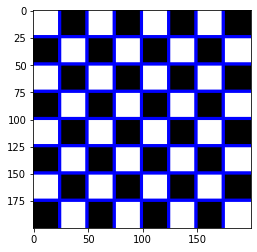

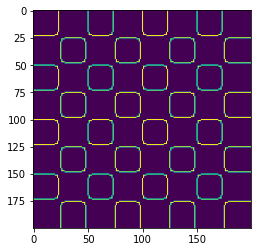

In [0]:
shapes = cv2.imread('/content/chess.png')
plt.imshow(shapes)
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()
shapes_grayscale = cv2.cvtColor(shapes, cv2.COLOR_RGB2GRAY)

# blur image (this will help clean up noise for Canny Edge Detection)
# see Chapter 2.0 for Guassian Blur or check OpenCV documentation
shapes_blurred = cv2.GaussianBlur(shapes_grayscale, (5, 5), 1.5)

# find Canny Edges and show resulting image
canny_edges = cv2.Canny(shapes_blurred, 100, 200)
plt.imshow(canny_edges)
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()

HOUGH LINES FROM SCRATCH USING NUMPY
Step 1: The Hough transform needs a binary edges images.  For this particular
using the openCV built in Class Canny to create this edge image


In [0]:
def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    ''' A function for creating a Hough Accumulator for lines in an image. '''
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes

    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas

This is a simple peaks function that just finds the indicies of the number
of maximum values equal to num_peaks.  You have to be careful here though, if
there's any noise in the image it will like create a 'pocket' of local maxima
values.  This function ignores this and in turn has the tendancy to return
multiple lines along an actual line in the image.

In [0]:

def hough_simple_peaks(H, num_peaks):
    ''' A function that returns the number of indicies = num_peaks of the
        accumulator array H that correspond to local maxima. '''
    indices =  np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T


This more advance Hough peaks funciton has threshold and nhood_size arguments
threshold will threshold the peak values to be above this value if supplied,
where as nhood_size will surpress the surrounding pixels centered around
the local maximum after that value has been assigned as a peak.  This will
force the algorithm to look eslwhere after it's already selected a point from
a 'pocket' of local maxima.

In [0]:
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    ''' A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpessed. '''
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size/2)
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size/2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size/2)
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size/2) + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(int(min_x),int(max_x)):
            for y in range(int(min_x),int(max_x)):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H

In [0]:
# a simple funciton used to plot a Hough Accumulator
def plot_hough_acc(H, plot_title='Hough Accumulator Plot'):
    ''' A function that plot a Hough Space using Matplotlib. '''
    fig = plt.figure(figsize=(10, 10))
    fig.canvas.set_window_title(plot_title)
    	
    plt.imshow(H, cmap='jet')

    plt.xlabel('Theta Direction'), plt.ylabel('Rho Direction')
    plt.tight_layout()
    plt.show()


In [0]:
# drawing the lines from the Hough Accumulatorlines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    ''' A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. '''
    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)




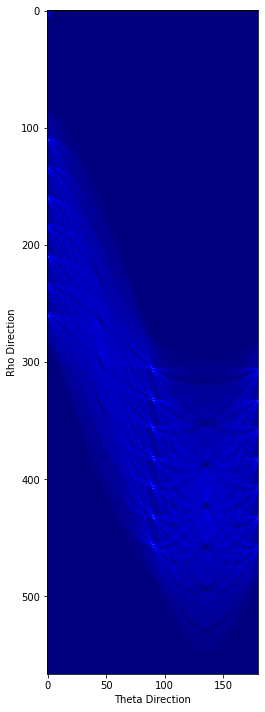

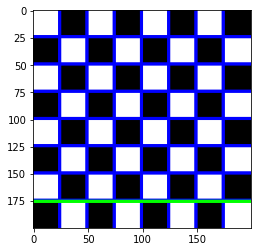

In [0]:
# run hough_lines_accumulator on the shapes canny_edges image
H, rhos, thetas = hough_lines_acc(canny_edges)
indicies, H = hough_peaks(H, 3, nhood_size=11) # find peaks
plot_hough_acc(H) # plot hough space, brighter spots have higher votes
hough_lines_draw(shapes, indicies, rhos, thetas)

# Show image with manual Hough Transform Lines
plt.imshow(shapes)
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()